# Imports

In [1]:
import importlib
import functions as f  # Our defined functions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

importlib.reload(f)

GRatio = (1 + 5 ** .5) / 2

WIDTH = .5
DASH = (10, 10)


# Solving models

Model verified.
Writing model to file models/SIRS_deaths.json.
File name already exists.


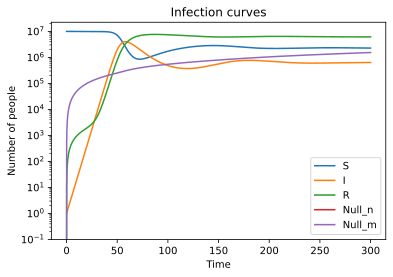

Pop variation: -940350


In [16]:
name = 'SIRS_deaths'
model = f.loadModel(name)
solution, t_span = f.solve(model, (0, 300), 100)

fig = plt.figure()
f.plotCurves(t_span,
             np.transpose(solution),
             toPlot=list(range(solution.shape[1])),
             labels=f.getCompartments(model))
plt.yscale('log')
plt.ylim(bottom=.1)
plt.show()

print(f"Pop variation: {f.getPopChange(model, solution):+.0f}")


Model verified.
Writing model to file models/SIRS_vars.json.
File name already exists.


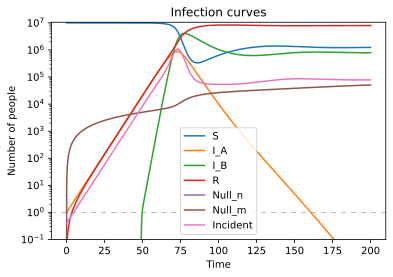

Pop variation: -31057
{'Rt(S,I_A)': 1.9979958523388357, 'Rt(S,I_B)': 0.0}


In [17]:
modelName = 'SIRS_vars'

model = f.loadModel(modelName)
solution, t_span = f.solve(model, (0, 200), 100)

# SIRS_deaths2 = f.mod(SIRS_deaths)
# solution2, t_span2 = f.solve(SIRS_deaths2, (0, 200), 100)

fig = plt.figure()
f.plotCurves(t_span,
             np.transpose(solution),
             toPlot=list(range(solution.shape[1])),
             labels=f.getCompartments(model))
plt.plot(t_span, f.infCurve(model, solution, t_span), label='Incident')
plt.ylim(bottom=.1)
plt.legend(loc='best')
plt.axhline(y=1, linestyle='--', color='grey', linewidth=WIDTH, dashes=DASH)
plt.yscale('log')
plt.show()

popChange = f.getPopChange(model, solution)
print(f"Pop variation: {popChange:.0f}")

f.mod(model)

model, modelMod, _, r0 = f.computeR0(
    modelName, (0, 300), printInit=False, printWarnings=False,
    autoInfections=True, scaledInfs=False, printText=False)

print(r0)


# $\mathcal{R}_t$ curves

Initializing with values {'S': 10000000.0, 'I': 1.0, 'Null_n': 0.0, 'Null_m': 0.0}.
NewDelta: [0, 0.4, 0, 0]
Init done. Values for layer 0: [0, 0.4]
           Values for layer 1: [10000000.0, 0.6]

Scaled: False, Auto: True
Time difference is not relevant, no intersection between rt and 1.


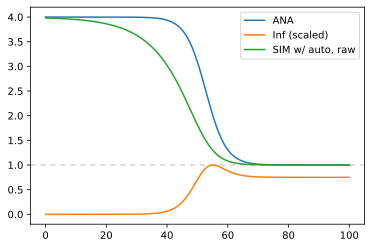

In [18]:
rtCurves, newInfs, rt_ANA = f.compare(
    "SIS", (0, 100), R0=4, write=True, printInit=True)
plt.show()



Scaled: False, Auto: True
72.5
Rt = 1 at 72.5
Moments where susceptibles < difference (i.e. problems): [ 75.13  75.14  75.15 ...  99.98  99.99 100.  ]
Difference (S - I) at time of importance: 2984617.558573553
Susceptibles at problem time:             2984548.2887240984
Susceptibles just before:                 2993420.7003717436
Time difference: 0.9699999999999989


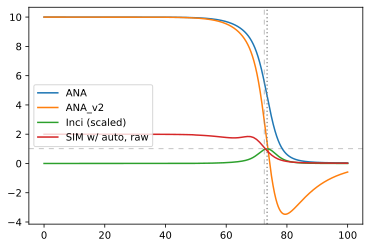

In [57]:
importlib.reload(f)

rtCurves = \
    f.compare("SIR_vars", (0, 100), 1, R0=10,
              plotANA=True, plotANA_v2=True, susceptibles=[0], infected=[1, 2])
plt.show()



Scaled: False, Auto: True
Rt = 1 at 30.250
Rt_ANA_v2 = 1 at 30.325
Lower bound respected? No
Moments where susceptibles < difference (i.e. problems): [31.85 31.86 31.87 31.88 31.89 31.9  31.91 31.92 31.93 31.94 31.95 31.96
 31.97 31.98 31.99 32.   32.01 32.02 32.03 32.04 32.05 32.06 32.07 32.08
 32.09 32.1  32.11 32.12 32.13 32.14 32.15 32.16 32.17 32.18 32.19 32.2
 32.21 32.22 32.23 32.24 32.25 32.26 32.27 32.28 32.29 32.3  32.31 32.32
 32.33 32.34 32.35 32.36 32.37 32.38 32.39 32.4  32.41 32.42 32.43 32.44
 32.45 32.46 32.47 32.48 32.49 32.5  32.51 32.52 32.53 32.54 32.55 32.56
 32.57 32.58 32.59 32.6  32.61 32.62 32.63 32.64 32.65 32.66 32.67 32.68
 32.69 32.7  32.71 32.72 32.73 32.74 32.75 32.76 32.77 32.78 32.79 32.8
 32.81 32.82 32.83 32.84 32.85 32.86 32.87 32.88 32.89 32.9  32.91 32.92
 32.93 32.94 32.95 32.96 32.97 32.98 32.99 33.   33.01 33.02 33.03 33.04
 33.05 33.06 33.07 33.08 33.09 33.1  33.11 33.12 33.13 33.14 33.15 33.16
 33.17 33.18 33.19 33.2  33.21 33.22 33.23 33.24

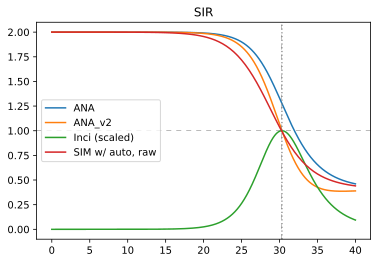

In [27]:
importlib.reload(f)

rtCurves = \
    f.compare("SIR", (0, 40), 2, R0=5,
              plotANA=True, plotANA_v2=True, susceptibles=[0], infected=[1])
plt.show()



Scaled: True, Auto: True
81.5
Rt = 1 at 81.5
Moments where susceptibles < difference (i.e. problems): [ 90.45  90.46  90.47  90.48  90.49  90.5   90.51  90.52  90.53  90.54
  90.55  90.56  90.57  90.58  90.59  90.6   90.61  90.62  90.63  90.64
  90.65  90.66  90.67  90.68  90.69  90.7   90.71  90.72  90.73  90.74
  90.75  90.76  90.77  90.78  90.79  90.8   90.81  90.82  90.83  90.84
  90.85  90.86  90.87  90.88  90.89  90.9   90.91  90.92  90.93  90.94
  90.95  90.96  90.97  90.98  90.99  91.    91.01  91.02  91.03  91.04
  91.05  91.06  91.07  91.08  91.09  91.1   91.11  91.12  91.13  91.14
  91.15  91.16  91.17  91.18  91.19  91.2   91.21  91.22  91.23  91.24
  91.25  91.26  91.27  91.28  91.29  91.3   91.31  91.32  91.33  91.34
  91.35  91.36  91.37  91.38  91.39  91.4   91.41  91.42  91.43  91.44
  91.45  91.46  91.47  91.48  91.49  91.5   91.51  91.52  91.53  91.54
  91.55  91.56  91.57  91.58  91.59  91.6   91.61  91.62  91.63  91.64
  91.65  91.66  91.67  91.68  91.69  91.7   9

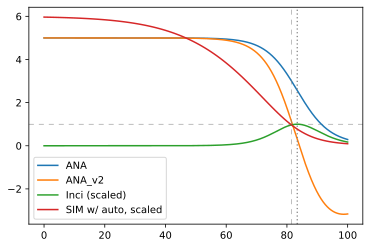


Scaled: True, Auto: True
126.5
Rt = 1 at 126.5
Moments where susceptibles < difference (i.e. problems): [135.   135.01 135.02 ... 199.98 199.99 200.  ]
Difference (S - I) at time of importance: 4626594.805254352
Susceptibles at problem time:             4624957.070814349
Susceptibles just before:                 4626637.546317157
Time difference: 0.03999999999999204


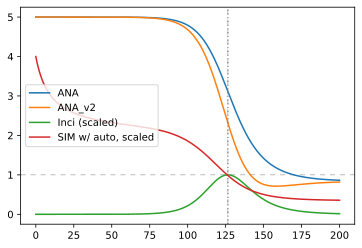

In [60]:
importlib.reload(f)

rtTimes, rtCurves, infsNotScaled = \
    f.compare("SIR_test", (0, 100), 1, R0=5,
              whereToAdd='to', scaledToPlot=['True'],
              plotANA=True, plotANA_v2=True, susceptibles=[0], infected=[1, 2, 3])
plt.show()

rtTimes, rtCurves, infsNotScaled = \
    f.compare("SIR_test2", (0, 200), 1, R0=5,
              whereToAdd='to', scaledToPlot=['True'],
              plotANA=True, plotANA_v2=True, susceptibles=[0], infected=[1, 2])
plt.show()


In [21]:
# infsEvery100 = infsNotScaled[::100]
# dinfs = infsEvery100[1:] - infsEvery100[:-1]
# product = (np.array(rtCurves[0]['Sum']) - 1) * infsEvery100

# plt.plot(rtTimes[:-1], (product[:-1] / 2 + product[1:] / 2) / dinfs)


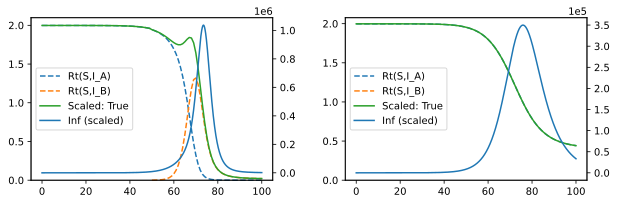

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

model, newModel, solution, t_span, values = f.computeRt(
    'SIR_vars', (0, 100), sub_rt=1, autoInfections=True,
    scaledInfs=True, write=False, printText=False,
    printInit=False, printWarnings=False)

rt_times = np.array([key for key in values])
rt = np.zeros_like(rt_times, dtype='float64')
for rtNode in f.getRtNodes(f.mod(model, False, False)):
    rt_rtNode = np.array([values[key][rtNode] for key in values])

    idx = np.where(rt_rtNode > 0)
    if len(f.getRtNodes(f.mod(model, False, False))) > 1:
        ax1.plot(rt_times[idx], rt_rtNode[idx], label=rtNode, linestyle='--')
    rt += rt_rtNode


idx = np.where(rt > 0)
ax1.plot(rt_times[idx], rt[idx], label=f'Scaled: {True}')

ax1.set_ylim(bottom=0)

ax3 = ax1.twinx()
infsScaled = f.infCurve(model, solution, t_span)
ax3.plot(t_span, infsScaled, label='Inf (scaled)')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()

ax1.legend(lines + lines2, labels + labels2, loc='center left')

# -------------------

model, newModel, solution, t_span, values = f.computeRt(
    'SIR_vars_noB', (0, 100), sub_rt=1, autoInfections=True,
    scaledInfs=True, write=False, printText=False,
    printInit=False, printWarnings=False)

rt_times = np.array([key for key in values])
rt = np.zeros_like(rt_times, dtype='float64')
for rtNode in f.getRtNodes(f.mod(model, False, False)):
    rt_rtNode = np.array([values[key][rtNode] for key in values])

    idx = np.where(rt_rtNode > 0)
    if len(f.getRtNodes(f.mod(model, False, False))) > 1 and len(idx) > 0:
        ax2.plot(rt_times[idx], rt_rtNode[idx], label=rtNode, linestyle='--')
    rt += rt_rtNode


idx = np.where(rt > 0)
ax2.plot(rt_times[idx], rt[idx], label=f'Scaled: {True}')

ax2.set_ylim(bottom=0)

ax4 = ax2.twinx()
infsScaled = f.infCurve(model, solution, t_span)
ax4.plot(t_span, infsScaled, label='Inf (scaled)')

lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax4.get_legend_handles_labels()

ax2.legend(lines + lines2, labels + labels2, loc='center left')

ax4.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))


plt.subplots_adjust(wspace=.3)

plt.show()


Model verified.
Writing model to file models/SIR_vars.json.
File name already exists.


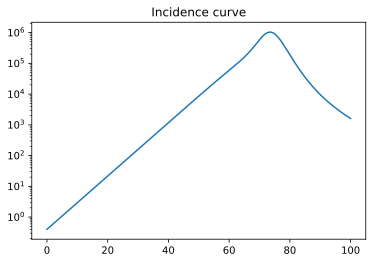

In [23]:
model = f.loadModel('SIR_vars')

solution, t_span = f.solve(model, (0, 100), 100)

infsScaled = f.infCurve(model, solution, t_span)
plt.plot(t_span, infsScaled, label='Infections')
plt.title('Incidence curve')

plt.yscale('log')

plt.show()


Overwriting file.
{'Rt(S,I_A)': 1.9979957793163483, 'Rt(S,I_B)': 0.0}


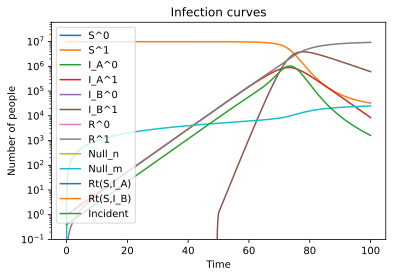

In [24]:
importlib.reload(f)

model, model_mod, initialConds, R0 = f.computeR0(
    "SIR_vars", write=True, overWrite=True, whereToAdd='contact',
    printInit=False, printText=False)

print(R0)

newModel = f.mod(model, False, False)
solution, t_span = f.solve(newModel, (0, 100), 100)

fig = plt.figure()
f.plotCurves(t_span,
             np.transpose(solution),
             toPlot=list(range(solution.shape[1])),
             labels=f.getCompartments(newModel))
plt.plot(t_span, f.infCurve(newModel, solution, t_span), label='Incident')
plt.yscale('log')
plt.ylim(bottom=.1)
plt.legend(loc='best')
plt.show()


In [25]:
# Intégration symbolique

# import sympy as sym
# from sympy import exp
# tInt = sym.symbols('tInt')
# func = 'exp(-tInt)'

# sym.init_printing()

# sym.print_latex(sym.integrate(func, tInt))
# sym.print_latex(eval(func))
# sym.print_latex(sym.diff(func))


In [26]:
importlib.reload(f)

name = 'SIR_test'
measures = {
    'layerDistance': '2cm',
    'nodeDistance': '2cm',
    'varDistance': '.5cm',
    'nullDistance': '.8cm',
    'baseAngle': 10,
    'contactPositions': ("2/5", "3/5")
}

# f.printModel(f.loadModel(name, True, False))

f.createLaTeX(f.loadModel(name, True, False), **measures)

f.createLaTeX(f.mod(f.loadModel(name, True, False),
                    overWrite=True), **measures)


Overwriting file.
This code doesn't work for 3 variants or more yet.
This code doesn't work for 3 variants or more yet.
This code doesn't work for 3 variants or more yet.
Overwriting file.
Overwriting file.
This code doesn't work for 3 variants or more yet.
This code doesn't work for 3 variants or more yet.
This code doesn't work for 3 variants or more yet.
This code doesn't work for 3 variants or more yet.
This code doesn't work for 3 variants or more yet.
This code doesn't work for 3 variants or more yet.
